In [1]:
import tensorflow as tf
from tensorflow import keras as keras

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg

<h1>Loading track</h1>

In [7]:
class Track:
    def __init__(self, base_image, spawn_at):
        """
        Convert RGB to Grey-Scale.
        Image expected to be of n x m
        """
        res=base_image.astype('int16')
        self.track=res
        self.spawn_at=spawn_at

        return 

In [385]:
img = mpimg.imread("track_pic9.jpg")[:,:,0]

In [331]:
np.unique(img)

array([0.        , 0.01960784, 0.05882353, 0.09803922, 0.11372549,
       0.12941177, 0.15686275, 0.18039216, 0.20784314, 0.23921569,
       0.26666668, 0.3019608 , 0.33333334, 0.3647059 , 0.41568628,
       0.4509804 , 0.49411765, 0.5254902 , 0.5803922 , 0.6156863 ,
       0.6627451 , 0.73333335, 0.78039217, 0.8039216 , 0.8392157 ,
       0.8627451 , 0.8745098 , 0.8901961 , 0.90588236, 0.92156863,
       0.93333334, 0.9490196 , 0.9647059 , 0.9882353 , 1.        ],
      dtype=float32)

(882, 1174)


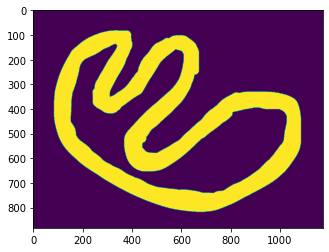

In [388]:
track1=(img<150).astype('int')
print(track1.shape)
track_rows, track_cols=track1.shape
pos_pos=np.where(track1==1)
spawning_positions=np.zeros((len(pos_pos[0]), 2))
spawning_positions[:, 0]=pos_pos[0]
spawning_positions[:, 1]=pos_pos[1]
spawning_positions=spawning_positions.astype('int')

track=Track(track1, spawning_positions)
plt.imshow(track1)

<i>Verify that track is 1 and off track 0<i>

In [389]:
track1[100, 100]

0

<h1> The car class</h1>

In [8]:
class Car:
    """
    The car object has the following attributes:
    1. Track - the associated track
    2. spawn_at: Possible spawning indices
    3. current position: Current position on the track. Floating point coordinate.
    4. integer_position_: defined as current_position.astype('int16')
    5. Bool collided_on_last
    6. sensors: LIDAR type function
    7. init_speed_
    8. max_speed
    9. sampling frequency: The frequency of play.
    10. speed: Current speed
    11. car_angle: current car angle as define below.
    """ 
    
    
   
    def __init__(self, track, max_speed, spawn_at):
        
        """
        track: The track as a binary array
        max_speed: Max attainable speed
        spawn_at: The possible spawning positions for the car. One among this is chosen.
        """
        
        """
        car angle is defined as the angle from the angle from
        the standard mathematical X axis, i.e., 
        y ^
          |
          |
          |
          -------> x
        Positive is ACW.
        """
        self.track=track
        
        self.possible_position=spawn_at
        self.current_position=self.possible_position[np.random.choice(range(len(self.possible_position)))]
        self.integer_position_=self.current_position.astype('int16')
        self.collided_on_last=None
    
        self.init_speed__=0
        self.speed=self.init_speed__
        self.max_speed=max_speed
        self.sampling_frequency=10

        self.car_angle=np.random.uniform(0, 1)*2*np.pi
        
        self.sensors=np.zeros((8,))
        self.load_sensors()


        return
    
    def duplicate(self):
        """
        Return: A car object, completely mimicing the current car object in every way.
        """
        car=Car(self.track, self.max_speed, self.spawn_at)
        car.current_position=car.current_position*0+self.current_position
        car.integer_position_=car.current_position.astype('int16')
        car.collided_on_last=self.collided_on_last
        
        car.speed=self.speed
        car.car_angle=self.car_angle
        
        car.sampling_frequency=self.sampling_frequency
        car.load_sensors()
        
        return car
        
    
    def re_spawn(self):
        """
        Re-spawn the current car at a legal position. Consult spawn_at attribute.
        Set all car state attributes.
        """
        
        self.speed=self.init_speed__
        self.current_position=self.possible_position[np.random.choice(range(len(self.possible_position)))]
        self.integer_position_=self.current_position.astype('int16')
        self.collided_on_last=None
        self.load_sensors()
        self.speed=self.init_speed__
        self.car_angle=np.random.uniform(0, 1)*2*np.pi
        return        
                
    def execute_forces(self, f1, f2, max_magnitudes=50):
        """
        Execute the forces.
        Update car state attributes:
            speed
            car_angle
            collided_on_last
            current_position, integer_position
            sensors
        """
        
        """
        f1 is the force in the vertical direction
        f2 is the force in the horizrontal direction

        ^
        |
        |     this is f1


        ------>  this is f2
        """

        """
        f1 is expected between -1, 1
        f2 is expected between -1, 1
        """

        f1=max_magnitudes*f1
        f2=max_magnitudes*f2
        if self.speed==0:
            if f1==0 or f2==0:
                if f1==0 and f2==0:
                    return
                elif f1!=0 and f2==0:
                    self.car_angle=np.pi/2
                    if f1<0:
                        self.car_angle=3*np.pi/2
                else:
                    self.car_angle=0
                    if f2<0:
                        self.car_angle=self.car_angle+np.pi
            else:
                abs_angle=np.arctan(abs(f1/f2))
                if f1>0 and f2>0:
                    self.car_angle=abs_angle
                elif f1>0 and f2<0:
                    self.car_angle=np.pi-abs_angle
                elif f1<0 and f2<0:
                    self.car_angle=np.pi+abs_angle
                else:
                    self.car_angle=2*np.pi-abs_angle
                
        """
        Skip this for game_v1
        Maintain constant speed for now.
        self.speed=min(
            abs(self.speed+(f2*np.cos(self.car_angle)+f1*np.sin(self.car_angle))*(1.0/self.sampling_frequency)),
            self.max_speed
        )
        """
        self.speed=self.max_speed
        delta_angle=0
        if self.speed!=0:
            delta_angle=np.arctan( (f1*np.cos(self.car_angle)-f2*np.sin(self.car_angle))
                /
                (self.speed*self.sampling_frequency)
                )
        self.car_angle=np.mod(self.car_angle+delta_angle, 2*np.pi)
        movement=np.asarray([
            -1*self.speed*np.sin(self.car_angle)*1.0/self.sampling_frequency, 
            self.speed*np.cos(self.car_angle)*1.0/self.sampling_frequency])
        if max(abs(movement))==0:
            print("Zero Movement recorded. Speed is: ", self.speed, " sampling_frequency is: ", self.sampling_frequency)

        old_position=np.zeros((2,))+self.current_position
        old_int_position=np.zeros((2,))+self.integer_position_
        self.current_position=self.current_position+movement
        self.integer_position_=self.current_position.astype('int16')
        if np.min(self.current_position+movement)<0 or (self.current_position+movement>=self.track.shape).any() or self.track[self.integer_position_[0], self.integer_position_[1]]!=1:
            for distance in range(0, int(np.ceil(self.max_speed*self.sampling_frequency))+1):
                movement=np.asarray([-distance*np.sin(self.car_angle), distance*np.cos(self.car_angle)])
                temp_pos=old_int_position+movement
                temp_pos_int=temp_pos.astype('int16')
                if min(temp_pos_int)>=0 and (temp_pos_int<self.track.shape).all():
                    if self.track[temp_pos_int[0], temp_pos_int[1]]==1:
                        self.current_position=self.current_position*0+temp_pos
                        self.integer_position_=self.current_position.astype('int16')
                    else:
                        break
                else:
                    break
            self.speed=0
            self.collided_on_last=True
        else:
            self.collided_on_last=False
        self.load_sensors()

        return


    def load_sensors(self):
        """
        sensors will be at 
        0
        30
        60
        90
        -30
        -60
        -90
        180 (directly backward)
        degrees
        """
        angles=[0, np.pi/6, np.pi/3, np.pi/2, -np.pi/6, -np.pi/3, -np.pi/2, np.pi]
        temp_data=np.zeros((8, ))
        for angle_index in range(len(angles)):
            cur_angle=np.mod(self.car_angle+angles[angle_index], 2*np.pi)
            for distance in range(1, 101):
                r, c=int(self.integer_position_[0]-distance*np.sin(cur_angle)), int(self.integer_position_[1]+distance*np.cos(cur_angle))
                if min(r, c)<0 or r>=self.track.shape[0] or c>=self.track.shape[1]:
                    temp_data[angle_index]=distance-1
                    break
                if self.track[r, c]==0:
                    temp_data[angle_index]=distance-1
                    break
                if distance==100:
                    temp_data[angle_index]=distance
        self.sensors[0]=temp_data[7]
        self.sensors[4]=temp_data[0]
        self.sensors[5]=temp_data[1]
        self.sensors[6]=temp_data[2]
        self.sensors[7]=temp_data[3]
        self.sensors[1]=temp_data[6]
        self.sensors[2]=temp_data[5]
        self.sensors[3]=temp_data[4]
        return

<h6>Some testing</h6>

In [172]:
matplotlib.image.imsave

<function matplotlib.image.imsave(fname, arr, vmin=None, vmax=None, cmap=None, format=None, origin=None, dpi=100, *, metadata=None, pil_kwargs=None)>

In [11]:
track_rows, track_cols

(983, 995)

0 47.0 0
0 43.0 50
0 41.0 50
0 38.0 50
0 36.0 50
0 33.0 50
0 31.0 50
0 28.0 50
0 26.0 50
0 23.0 50
0 21.0 50
0 19.0 50
0 16.0 50
1 14.0 50
1 17.0 50
0 35.0 50
0 35.0 50
0 33.0 50
0 30.0 50
0 27.0 50
0 23.0 50
0 22.0 50
1 19.0 50
0 76.0 50
0 74.0 50
0 71.0 50
0 68.0 50
0 71.0 50
0 68.0 50
0 66.0 50
0 63.0 50
0 60.0 50
0 58.0 50
0 55.0 50
0 52.0 50
0 50.0 50
0 47.0 50
0 42.0 50
0 42.0 50
0 39.0 50
0 34.0 50
0 31.0 50
0 29.0 50
0 26.0 50
1 23.0 50
1 100.0 50
0 100.0 50
0 100.0 50
0 99.0 50
0 99.0 50
0 99.0 50
0 97.0 50
0 91.0 50
0 89.0 50
0 87.0 50
0 81.0 50
0 81.0 50
0 79.0 50
0 77.0 50
0 71.0 50
0 71.0 50
0 70.0 50
0 64.0 50
0 64.0 50
0 64.0 50
0 62.0 50
-1 56.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 

0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
0 100.0 50
-1 100.0 50
0 86.0 50
0 83.0 50
0 81.0 50
0 78.0 50
0 76.0 50
0 73.0 50
0 71.0 50
0 68.0 50
0 66.0 50
0 63.0 50
0 61.0 50
0 58.0 50
0 56.0 50
0 53.0 50
0 51.0 50
0 48.0 50
0 46.0 50
0 43.0 50
0 41.0 50
0 38.0 50
0 36.0 50
0 33.0 50
0 31.0 50
0 28.0 50
0 26.0 50
0 23.0 50
0 21.0 50
1 18.0 50
0 32.0 50
0 30.0 50
0 27.0 50
0 23.0 50
0 21.0 50
0 19.0 50
1 16.0 50
0 78.0 50
0 76.0 50
0 73.0 50
0 71.0 50
0 68.0 50
0 66.0 50
0 63.0 50
0 61.0 50
0 58.0 50
0 56.0 50
0 53.0 50
0 51.0 50
0 48.0 50
0 46.0 50
0 43.0 50
0 41.0 50
0 38.0 50
0 36.0 50
0 33.0 50
0 31.0 50
0 28.0 50
0 26.0 50
0 23.0 50
0 21.0 50
1 18.0 50
1 100.0 50
0 92.0 50
0 90.0 50
0 88.0 50
0 85.0 50
0 83.0 50
0 81.0 50
0 78.0 50
0 76.0 50
0 73.0 50
0 70.0 50
0 67.0 50
0 65.0 50
0 63.0 50
0 60.0 50
0 58.0 50
0 56.0 50
0 53.0 50
0 51.0 50

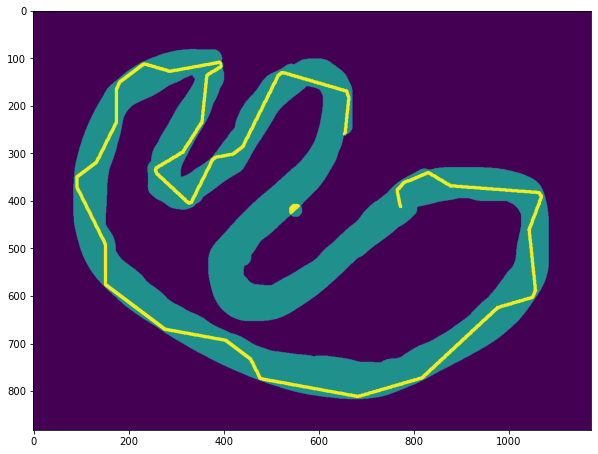

In [400]:
new_car=Car(track.track, 50, track.spawn_at)
new_car.sampling_frequency=20


def get_plot(positions, superimposeon_this):
    x, y=positions
    for x_diff in range(-30, 31):
        for y_diff in range(-30, 31):
            if np.sqrt(x_diff**2+y_diff**2)<14:
                superimposeon_this[x+x_diff][y+y_diff]=1
    f=plt.figure(figsize=(10, 20))
    plt.imshow(superimposeon_this+new_car.track)
    plt.show()
    return


base_fig=np.zeros((track_rows, track_cols))


for iteration in range(3000):
    r, c=new_car.integer_position_
    for x_diff in range(-7, 8):
        for y_diff in range(-7, 8):
            if np.sqrt(x_diff**2+y_diff**2)<4:
                if r+x_diff<new_car.track.shape[0] and c+y_diff<new_car.track.shape[1]:
                    base_fig[r+x_diff][c+y_diff]=1
                    
                    
    direction, best_action_value=get_opt_action(new_car, target_model, actions, data_scaler, usescaler)
    print(direction, new_car.sensors[4], new_car.speed)
    
    theta=new_car.car_angle
    if direction==-1:
        theta=theta+np.pi/2
    if direction==1:
        theta=theta-np.pi/2
        
    f1, f2=np.sin(theta), np.cos(theta)
    new_car.execute_forces(f1, f2, max_magnitudes=500)
    
    if new_car.collided_on_last:
        print("boom")
        break
        
get_plot(new_car.integer_position_, base_fig)
            
            

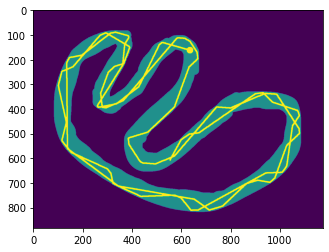

In [397]:
plt.imshow(base_fig+track1)

In [394]:
t=time.ctime()
l=[]
for i in t:
    if i==" ":
        continue
    if i==':':
        l.append("_")
    else:
        l.append(i)
target_model.save("final_correct_model"+"".join(l)+".h5")

<h1> Starting RL now.</h1>

In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Lambda, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, EarlyStopping

In [149]:
def get_model(layers, mode):
    model=Sequential()
    for i, layer_data in enumerate(layers):
        if layer_data[0]!='Lambda' and layer_data[0]!='lambda':
            num_nodes, l_activation, l_dropout=layer_data
            model.add(Dense(num_nodes, activation=l_activation))
            if mode=='Train':
                model.add(Dropout(l_dropout))
        else:
            lamb_func_=layer_data[1]
            num_nodes_prev=layers[i-1][0]
            model.add(Lambda(lamb_func_, output_shape=(None, num_nodes_prev)))
        if i<=4:
            model.add(LayerNormalization())
    model.add(Dense(1))
    return model

In [14]:
def custom_loss(y_true, y_pred):
    reward=y_true[:,0]
    target=y_true[:,1]
    return keras.backend.mean(keras.backend.abs(reward+0.8*target-y_pred))

In [15]:
"""
The epsilon greedy policy.
Remember, it should be Greedy in the limit of infinity
"""
def get_threshold(train_step):
    x=float(train_step)
    if x==0:
        return 0
    x=x/5
    return float(x)/(1+float(x))

In [16]:
def custom_scaler(train_x, scaler):
    train_x=train_x/scaler
    return train_x
    

<h1>Definition of actions:</h1><br>
<ul>  
<li>-1 is <i>Left</i><br>
<li> 0 is <i>As Is</i><br>
<li> 1 is <i>Right</i></ul>

In [17]:
actions=np.asarray([-1, 0, 1]) 

<h1> Description of the Replay Memory</h1><br>
The state will be sensors, speed, car_angle. So <b>10</b> values. State at time t<br>
The action will be a value.,  but it is encoded one hot. Since 3 possible actions, hence <b>3</b> array units. action at time t<br>
Next state <b>10</b> values.<br>
The reward will be speed*(speed_multiplier) or penalty if off track. So <b>1</b> value. Reward at time t<br>
The target reward is <b>1</b> value.<br>
So, replay memory needs <b>25</b> columns.<br>
<br>
<b>During training, we only supply the first 13 columns, except the 10<sup>th</sup>, to the network.</b><br>
Basically, we donot want to submit car_angle<br>
The last 2 columns are supplied in y_true, and are used  in loss computation.<br>

In [18]:
def get_opt_action(car, network, actions, data_scaler, usescaler):
    m1=np.ones((3, 1))
    state=np.zeros((1, 9))
    state[0, :8]=car.sensors
    state[0, 8]=car.speed
    test_x=np.hstack((np.matmul(m1, state), np.eye(3)))
    if usescaler:
        test_x=custom_scaler(test_x, data_scaler)
    res=network.predict(test_x)
    best_action=np.argmax(res)
    if best_action==0:
        return -1, res
    if best_action==1:
        return 0, res
    if best_action==2:
        return 1, res
    
def update_replay_helper(states, network, actions, data_scaler, usescaler):
    """
    states is an N x 9 array, having, well, N states. 
    data scaler is an array of size 12 (number of features fed to the network).
    12=9 (i.e. the state) + 3(i.e. the action).
    It only scales, so no subtracting.
    
    Aim is to get the maximum value from this state
    """
    rows=len(states)
    m1=np.ones((rows, 1))
    one_hot_actions=np.eye(len(actions))
    
    max_value=np.full((rows, 1), -np.inf)
    
    for action_index in range(len(one_hot_actions)):
        temp=np.matmul(m1, one_hot_actions[action_index].reshape((1, -1)))
        network_input=np.hstack((states, temp))
        if usescaler:
            network_input=custom_scaler(network_input, data_scaler)
        max_value=np.maximum(max_value, network.predict(network_input))
        
    return max_value

In [339]:
def populate_replay_memory(car, network, actions, replay_memory, insert_index,
                          rows_to_fill, data_scaler, usescaler, train_step):
    global exploration
    
    if np.random.choice([0, 1]):
        car.re_spawn()
        
    for i in range(rows_to_fill):
        
        row_data=np.zeros((1, 25))
        row_data[0, :8]=row_data[0, :8]+car.sensors
        row_data[0, 8]=car.speed
        row_data[0, 9]=car.car_angle
        
        # choose an action
        x=np.random.uniform(0, 1)
        if x>get_threshold(train_step):
            direction=actions[np.random.choice(range(len(actions)))]
        else:
            direction, best_action_value=get_opt_action(car, network, actions, data_scaler, usescaler)
        
        # prepare action
        if direction==0:
            one_hot_direction=[0, 1, 0]
        elif direction==-1:
            one_hot_direction=[1, 0, 0]
        else:
            one_hot_direction=[0, 0, 1]
        row_data[0, 10:13]=one_hot_direction
        old_angle=car.car_angle
        theta=car.car_angle
        if direction==-1:
            theta=np.mod(theta+np.pi/2, 2*np.pi)
        elif direction==1:
            theta=np.mod(theta-np.pi/2, 2*np.pi)
            
        # execute it
        fin_f1, fin_f2=np.sin(theta), np.cos(theta)
        car.execute_forces(fin_f1, fin_f2, max_magnitudes=500)
        
        # update exploration
        exploration[car.integer_position_[0], car.integer_position_[1]]=1
        
        
        row_data[0, 13:21]=row_data[0, 13:21]+car.sensors
        row_data[0, 21]=car.speed
        row_data[0, 22]=car.car_angle
        
        # calculate reward
        if car.collided_on_last:
            rew=-500
        else:
            rew=car.speed/10
            
            
        row_data[0, 23]=rew
        row_data[0, 24]=0
        replay_memory[insert_index[0]]=replay_memory[insert_index[0]]*0+row_data
        insert_index[0]=(insert_index[0]+1)%len(replay_memory)
        
    return


def update_replay_memory(target_model, actions, replay_memory,
                         data_scaler, usescaler):
    # select the next state columns, except the car angle
    l=[i for i in range(13, 13+8+2) if i!=(13+7+2)]
    temp=replay_memory[:, l]
    
    # get the new target column that has max Q for each state
    res=update_replay_helper(temp, target_model, actions, data_scaler, usescaler)
    replay_memory[:, 24]=res.reshape((len(replay_memory), ))
    
    return

<h1>Here is the LR schedule</h1>

In [20]:
def schedule(epoch, lr):
    if epoch==15:
        lr=lr/4
    return lr

In [340]:
layers=[
(50, 'relu', 0.2),
(200, 'relu', 0.2),
(20, 'relu', 0.2),
(500, 'relu', 0.2)
]

target_model=get_model(layers, 'eval')

make_consistent_net=get_model(layers, 'train')

keep_safe=get_model(layers, 'eval')

"""
The following callbacks are for the make_consistent_net only.
"""
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min')
history=History()
learning_scheduler=LearningRateScheduler(schedule)

opt1=keras.optimizers.Adam(lr=0.001)
make_consistent_net.compile(loss=custom_loss, optimizer=opt1)
target_model.compile(loss=custom_loss, optimizer='adam')
keep_safe.compile(loss=custom_loss, optimizer='adam')

In [307]:
replay_size=400
replay_memory=np.zeros((replay_size, 25))
train_y=np.zeros((replay_size, 2))

In [312]:
val_loss_hist=[]
train_loss_hist=[]

In [313]:
np.where(exploration==1)

(array([], dtype=int64), array([], dtype=int64))

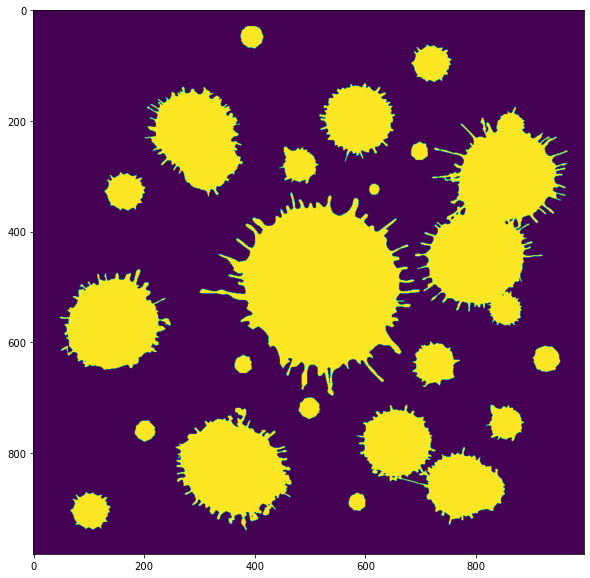

In [383]:
fig=plt.figure(figsize=(10, 10))
plt.imshow(exploration+track1)
plt.show()

In [381]:
global exploration
exploration=np.zeros((track_rows, track_cols))

In [382]:
car=Car(track.track, 50, track.spawn_at)
car.sampling_frequency=20.0

<h6> Declaring the training constants</h6>

In [345]:
insert_index=[0]
data_scaler=np.asarray([
    100, 100, 100, 100,
    100, 100, 100, 100,
    50, 1, 1, 1
])
gamma=0.8
usescaler=True
inputcolumns=[i for i in range(13) if i!=9]


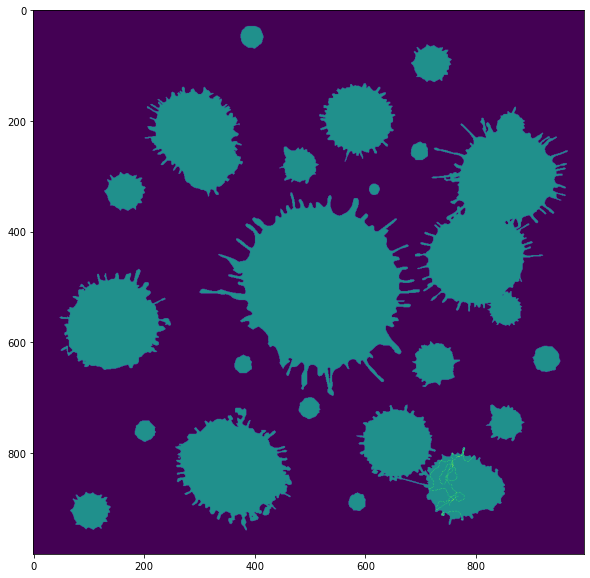

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 53.6926 - val_loss: 51.6987
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 49.0270 - val_loss: 43.9465
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 40.1347 - val_loss: 24.7056
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 38.2096 - val_loss: 15.4737
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 33.4211 - val_loss: 18.7224
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 60.3995 - val_loss: 64.3156
Epoch 2/5
360/360 [==============================] - 1s 3ms/sample - loss: 59.2627 - val_loss: 63.4880
Epoch 3/5
360/360 [==============================] - 1s 3ms/sample - loss: 58.7901 - val_loss: 63.6759
Epoch 4/5
360/360 [==============================] - 1s 3ms/sample - loss: 56.0588 - v

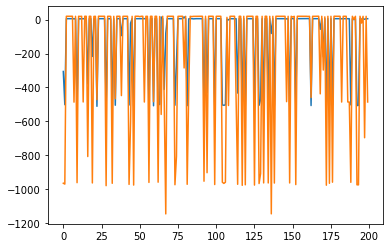

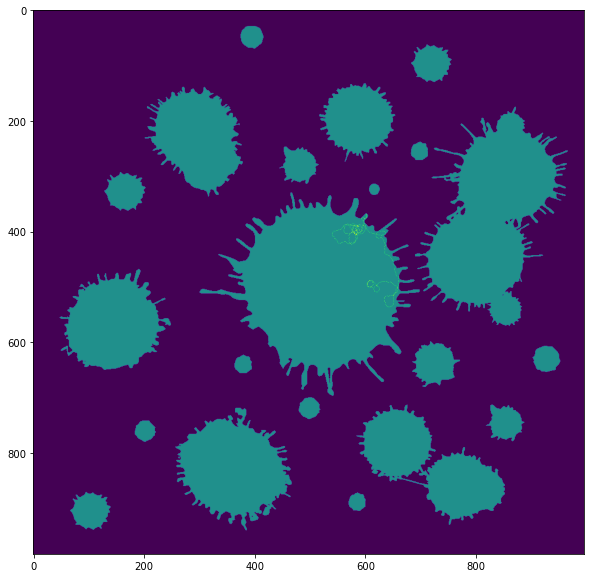

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 13.6247 - val_loss: 13.6505
Epoch 2/5
360/360 [==============================] - 1s 3ms/sample - loss: 11.4160 - val_loss: 11.1258
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 12.1718 - val_loss: 6.7135
Epoch 4/5
360/360 [==============================] - 1s 3ms/sample - loss: 11.8630 - val_loss: 12.4920
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 12.0369 - val_loss: 10.3019
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 16.3165 - val_loss: 18.6775
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 15.2004 - val_loss: 17.9166
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 16.2708 - val_loss: 18.7462
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 15.9739 - va

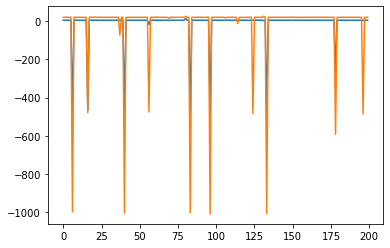

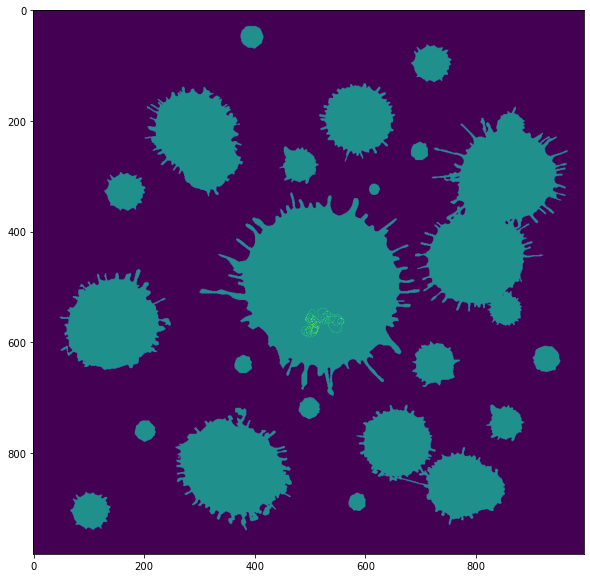

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.4860 - val_loss: 0.0942
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1374 - val_loss: 0.1098
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1386 - val_loss: 0.1223
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1392 - val_loss: 0.1318
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1387 - val_loss: 0.1298
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.2587 - val_loss: 0.0725
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0730 - val_loss: 0.0200
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0723 - val_loss: 0.0045
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0876 - val_loss: 0.0412
E

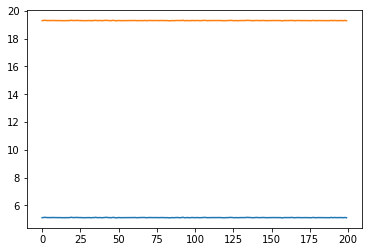

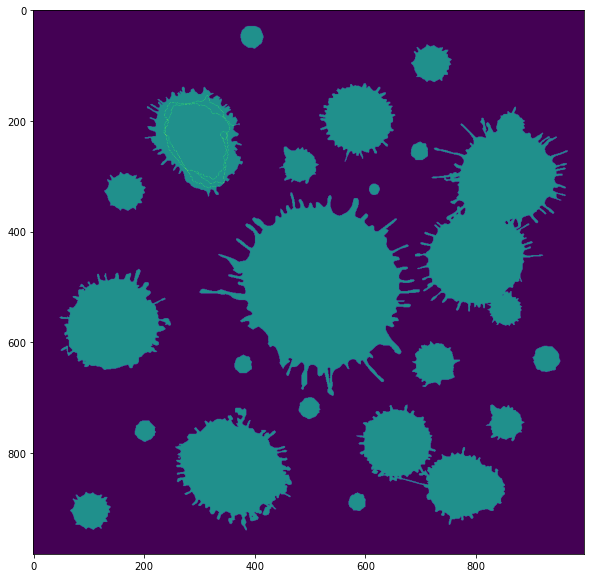

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.9273 - val_loss: 13.6437
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.4951 - val_loss: 13.1030
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.4487 - val_loss: 12.8215
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.2992 - val_loss: 12.1638
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.1681 - val_loss: 11.9054
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 5.0466 - val_loss: 8.5400
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 3.6701 - val_loss: 2.0067
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.7622 - val_loss: 0.5020
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.5659 - val_loss: 0.2

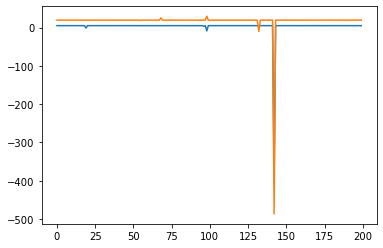

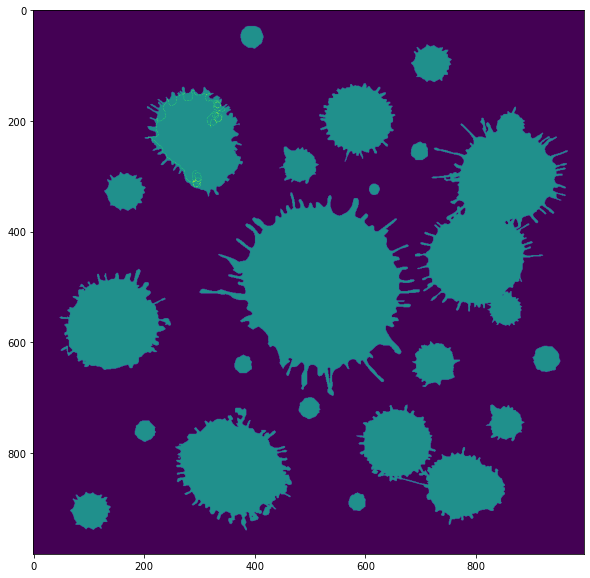

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 23.5200 - val_loss: 51.7546
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 19.7013 - val_loss: 52.0562
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 15.7664 - val_loss: 51.3004
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 14.7901 - val_loss: 50.8616
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 15.3693 - val_loss: 51.4532
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 18.6463 - val_loss: 50.8928
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 16.7797 - val_loss: 51.1878
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 16.6311 - val_loss: 51.2545
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 16.4497 - v

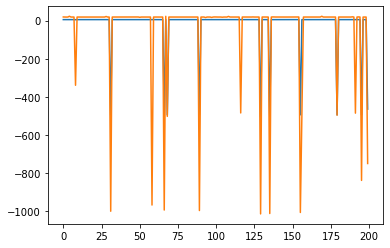

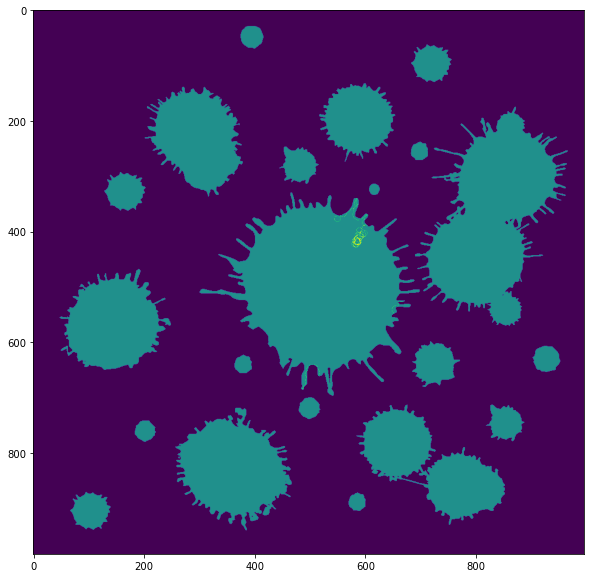

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 29.6709 - val_loss: 32.0773
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 28.6296 - val_loss: 29.9657
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 25.7670 - val_loss: 28.7554
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 24.3950 - val_loss: 28.5932
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 24.2753 - val_loss: 28.0408
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 37.5294 - val_loss: 37.3928
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 37.3598 - val_loss: 37.0373
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 37.4352 - val_loss: 36.6057
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 37.4660 - v

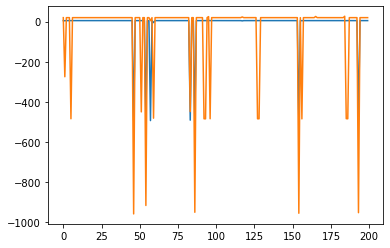

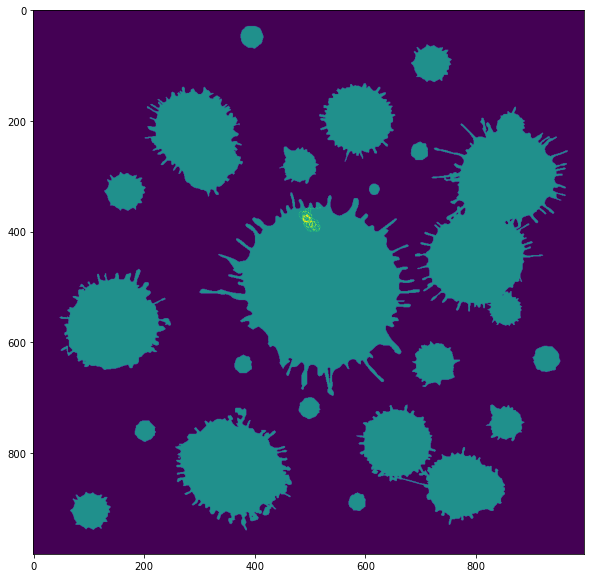

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 1.8139 - val_loss: 12.1746
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1600 - val_loss: 12.1457
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1495 - val_loss: 12.1075
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1520 - val_loss: 11.9292
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1960 - val_loss: 12.6327
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 1.4114 - val_loss: 12.2919
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 1.2564 - val_loss: 12.1705
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 1.3224 - val_loss: 12.1014
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 1.3161 - val_loss: 

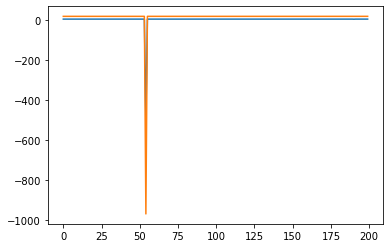

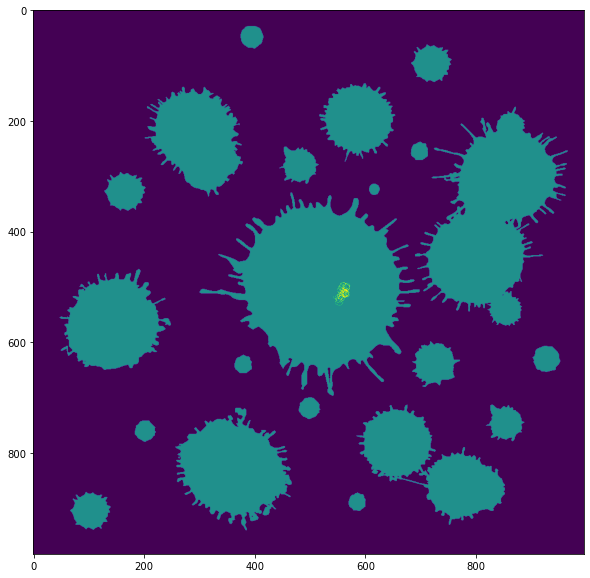

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.6151 - val_loss: 0.0712
Epoch 2/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.1854 - val_loss: 0.0695
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1853 - val_loss: 0.0751
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1853 - val_loss: 0.0858
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1852 - val_loss: 0.1001
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1778 - val_loss: 0.0481
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0769 - val_loss: 0.0612
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0768 - val_loss: 0.0731
Epoch 4/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.0768 - val_loss: 0.0845
E

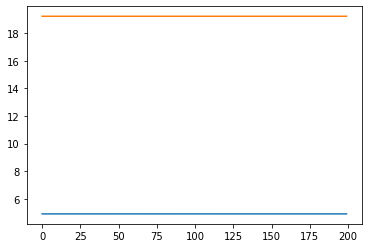

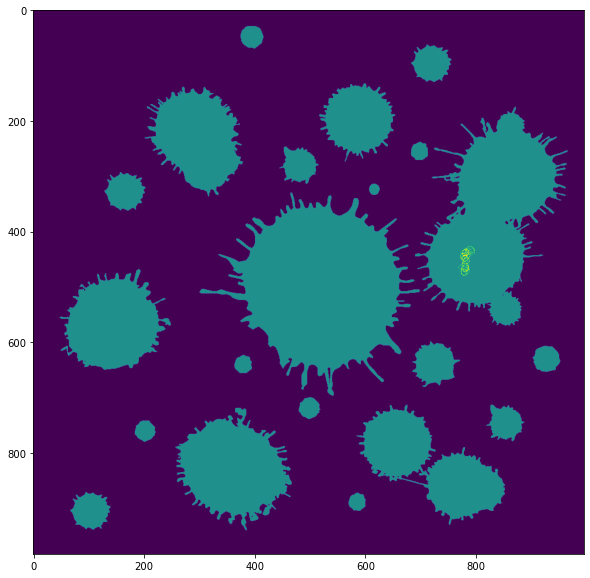

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.5176 - val_loss: 0.1338
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1192 - val_loss: 0.1378
Epoch 3/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.1189 - val_loss: 0.1336
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1200 - val_loss: 0.0263
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1258 - val_loss: 0.1376
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.2264 - val_loss: 0.1423
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0849 - val_loss: 0.0506
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0902 - val_loss: 0.1272
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0803 - val_loss: 0.0102
E

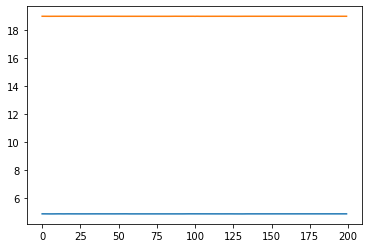

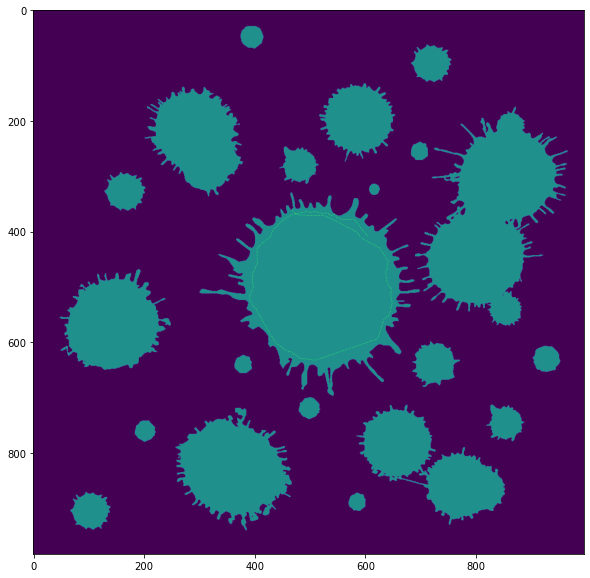

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 3.3395 - val_loss: 0.0336
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.8772 - val_loss: 0.1985
Epoch 3/5
360/360 [==============================] - 1s 3ms/sample - loss: 2.8812 - val_loss: 0.1975
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.8931 - val_loss: 0.0519
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.8789 - val_loss: 0.0401
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 3.0519 - val_loss: 0.0921
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.8832 - val_loss: 0.0850
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.9460 - val_loss: 0.0808
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.9569 - val_loss: 0.1537
E

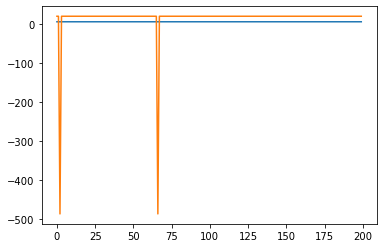

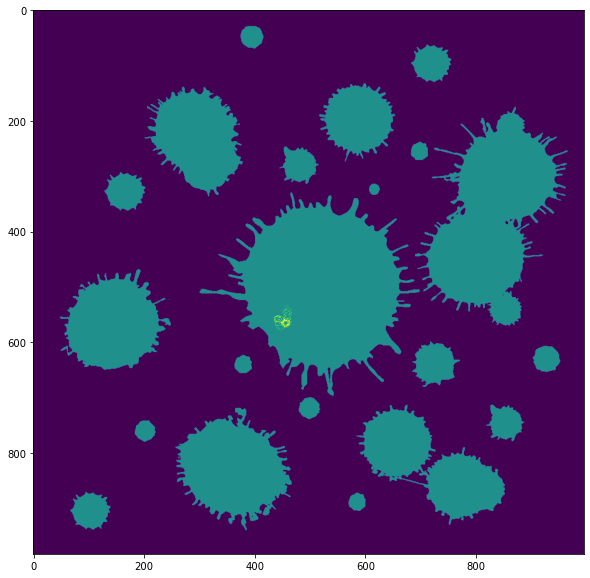

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.5180 - val_loss: 0.0465
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0820 - val_loss: 0.0503
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0795 - val_loss: 0.0815
Epoch 4/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.0866 - val_loss: 0.0541
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0892 - val_loss: 0.1344
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1998 - val_loss: 0.0489
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0890 - val_loss: 0.1284
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0988 - val_loss: 0.0374
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1224 - val_loss: 0.0043
E

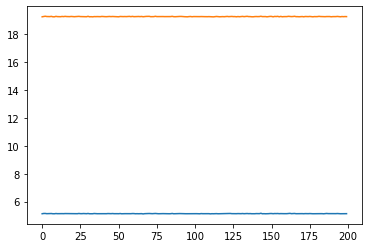

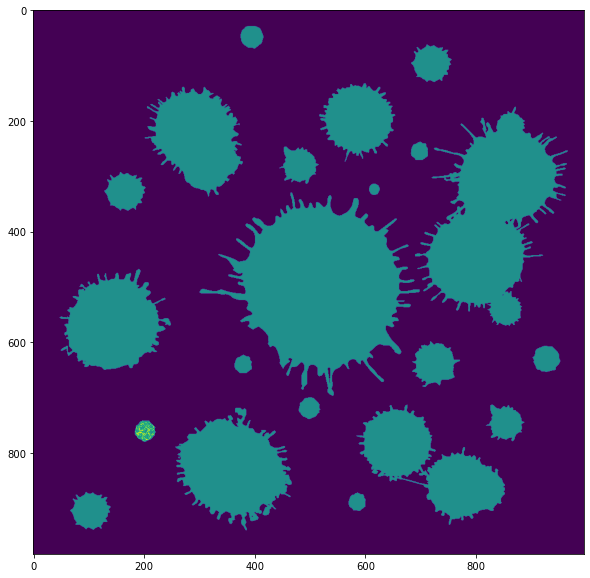

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 19.8780 - val_loss: 0.1974
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 15.6163 - val_loss: 0.2348
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 15.3593 - val_loss: 0.1048
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 14.0808 - val_loss: 0.2527
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 12.7058 - val_loss: 0.1868
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 21.8422 - val_loss: 0.5657
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 21.7696 - val_loss: 0.0987
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 18.9922 - val_loss: 0.0835
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 18.4718 - val_loss:

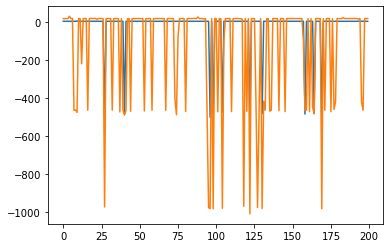

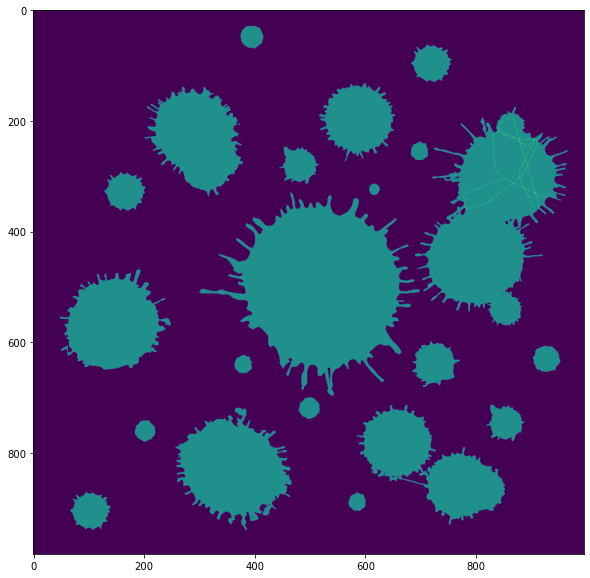

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.7128 - val_loss: 0.2002
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.2188 - val_loss: 0.1018
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.1618 - val_loss: 0.2123
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.2273 - val_loss: 0.0296
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.1144 - val_loss: 0.1147
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 9.6204 - val_loss: 0.2063
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 9.4966 - val_loss: 0.0229
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 9.4159 - val_loss: 0.1411
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 9.4000 - val_loss: 0.1523
E

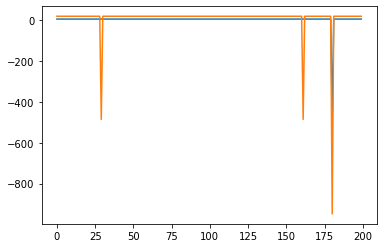

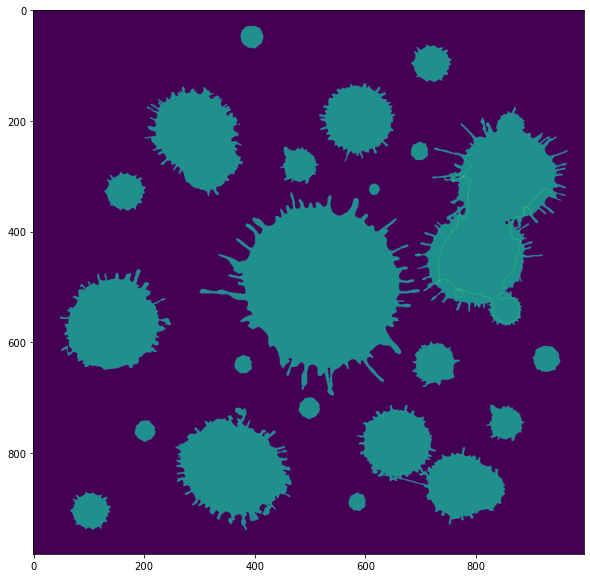

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 5.8066 - val_loss: 25.3416
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.3065 - val_loss: 25.2894
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.3142 - val_loss: 25.2566
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.2988 - val_loss: 25.2668
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.3030 - val_loss: 25.3063
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.4682 - val_loss: 25.4033
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.3239 - val_loss: 25.4198
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.3400 - val_loss: 25.3718
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.3487 - val_loss: 

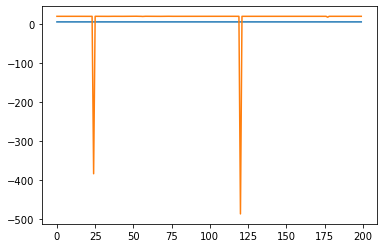

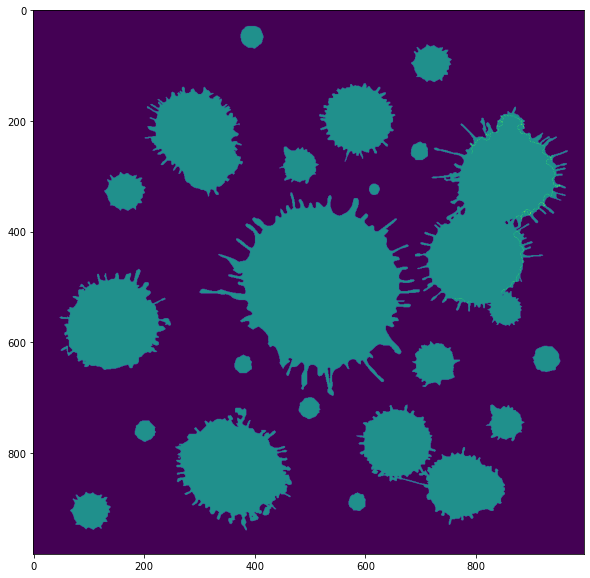

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 71.2474 - val_loss: 111.3590
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 69.5739 - val_loss: 109.4170
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 64.6027 - val_loss: 106.5505
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 65.2728 - val_loss: 106.2140
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 64.4811 - val_loss: 108.4330
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 85.7310 - val_loss: 126.2645
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 82.7694 - val_loss: 127.4703
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 82.6520 - val_loss: 127.5017
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 79.

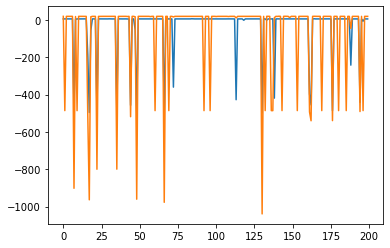

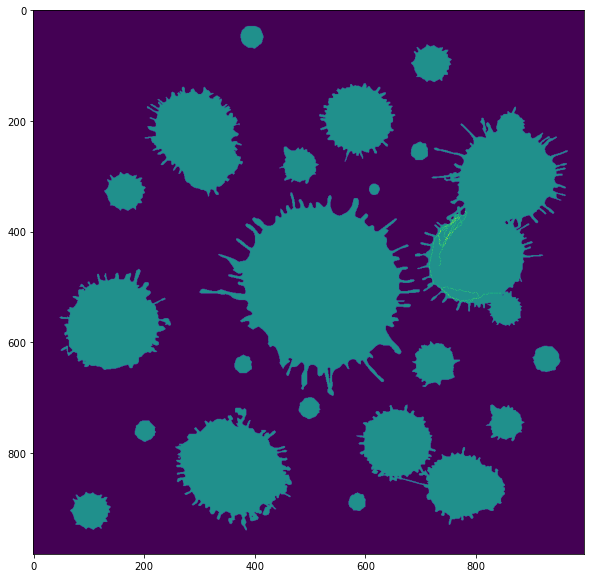

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.4839 - val_loss: 6.4158
Epoch 2/5
360/360 [==============================] - 1s 3ms/sample - loss: 8.4291 - val_loss: 7.0694
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.6956 - val_loss: 8.5459
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.2609 - val_loss: 8.4920
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 7.0427 - val_loss: 8.6019
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.2967 - val_loss: 8.9708
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.0188 - val_loss: 9.4863
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 9.8707 - val_loss: 11.4485
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 9.1176 - val_loss: 12.7

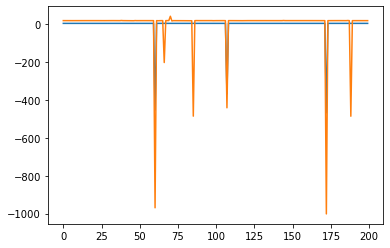

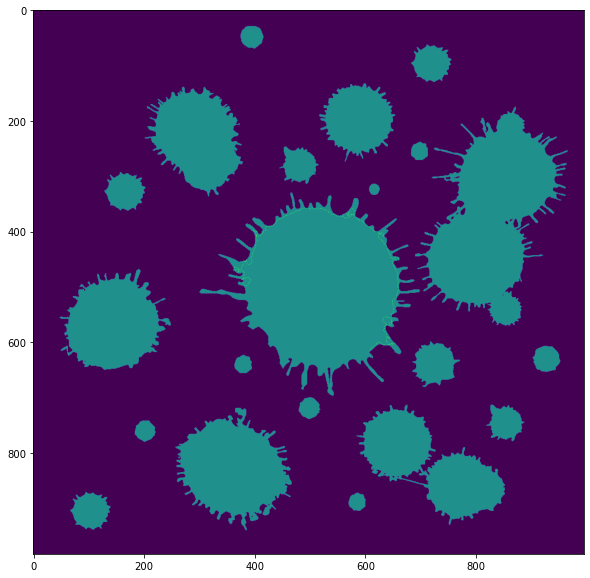

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 30.7248 - val_loss: 38.0105
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 31.6102 - val_loss: 37.9472
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 31.1274 - val_loss: 38.2299
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 31.0551 - val_loss: 37.9295
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 29.7449 - val_loss: 37.9151
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 32.2236 - val_loss: 38.0997
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 32.1997 - val_loss: 38.0918
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 32.2174 - val_loss: 37.9976
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 32.1764 - v

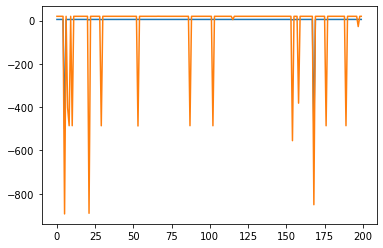

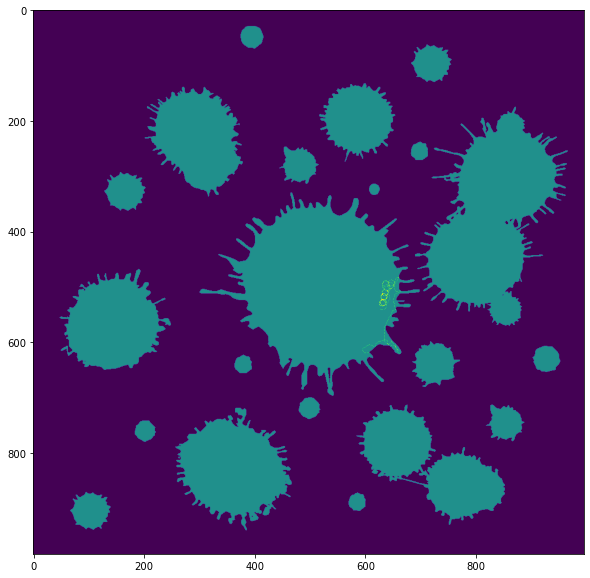

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 12.0593 - val_loss: 0.6506
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 11.4954 - val_loss: 1.1021
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.2662 - val_loss: 1.0089
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 11.3548 - val_loss: 1.2291
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 11.3263 - val_loss: 0.9798
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 14.4762 - val_loss: 1.2800
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 13.2351 - val_loss: 1.2669
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 14.3879 - val_loss: 1.6137
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 14.4636 - val_loss:

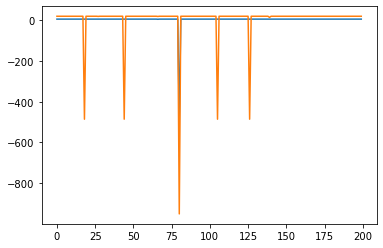

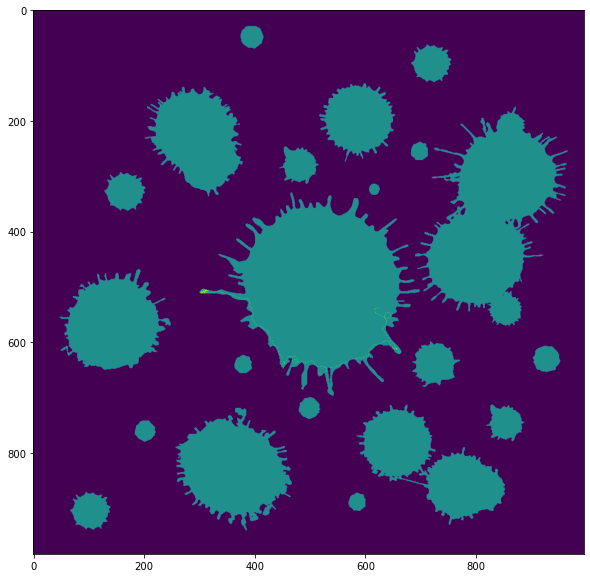

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 43.4747 - val_loss: 24.6632
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 32.2923 - val_loss: 25.7738
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 25.9557 - val_loss: 28.0273
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 23.1711 - val_loss: 27.2424
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 23.8173 - val_loss: 36.1778
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 44.7329 - val_loss: 35.0869
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 43.0233 - val_loss: 35.7291
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 43.5804 - val_loss: 38.9925
Epoch 4/5
360/360 [==============================] - 1s 3ms/sample - loss: 42.8978 - v

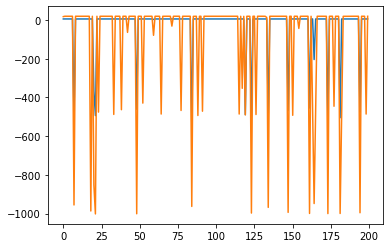

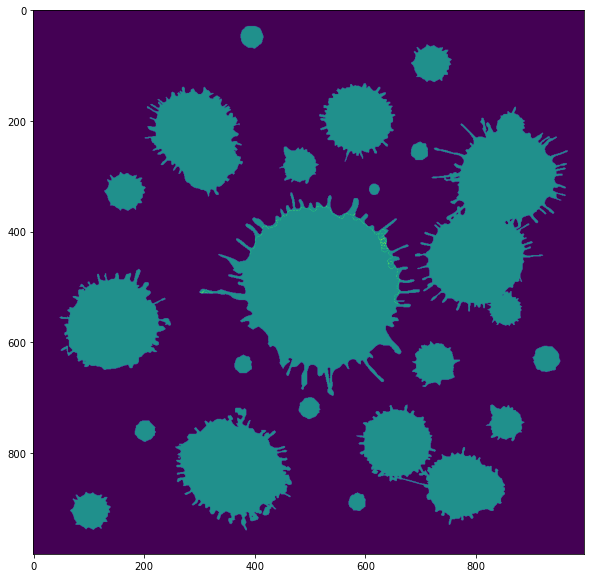

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 88.5925 - val_loss: 38.7464
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 44.2607 - val_loss: 39.6666
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 45.4361 - val_loss: 37.8609
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 39.2780 - val_loss: 38.8856
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 37.4151 - val_loss: 38.2335
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 45.5256 - val_loss: 48.2801
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 43.4414 - val_loss: 48.4026
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 41.8706 - val_loss: 48.8084
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 40.6755 - v

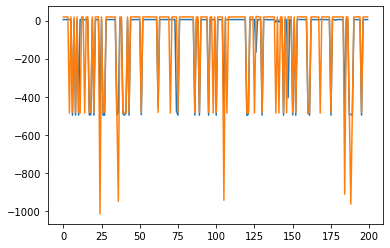

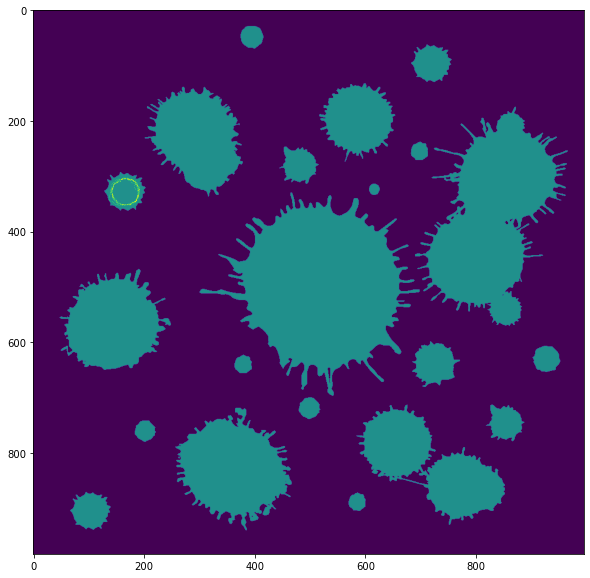

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.5381 - val_loss: 0.0164
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0768 - val_loss: 0.0803
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0630 - val_loss: 0.0755
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0535 - val_loss: 0.1023
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0620 - val_loss: 0.0831
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.2086 - val_loss: 0.0052
Epoch 2/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.1102 - val_loss: 0.0094
Epoch 3/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.0538 - val_loss: 0.0097
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0678 - val_loss: 0.0226
E

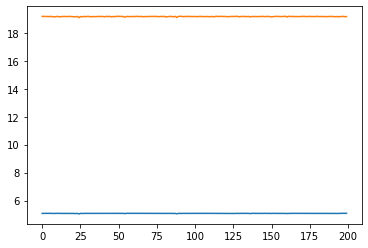

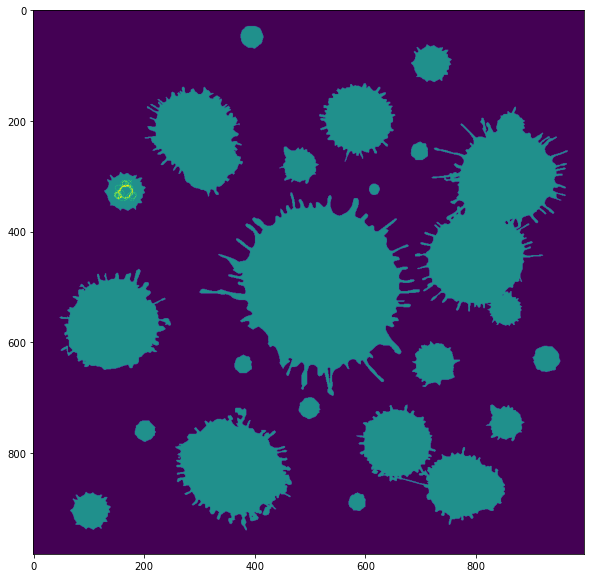

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.5526 - val_loss: 0.0598
Epoch 2/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.1081 - val_loss: 0.0395
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1056 - val_loss: 0.0901
Epoch 4/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.1039 - val_loss: 0.0930
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0968 - val_loss: 0.0820
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.2337 - val_loss: 0.1453
Epoch 2/5
360/360 [==============================] - 1s 3ms/sample - loss: 0.1190 - val_loss: 0.0276
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0751 - val_loss: 0.0036
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0785 - val_loss: 0.0470
E

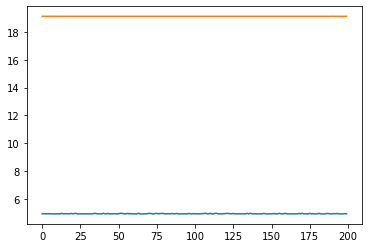

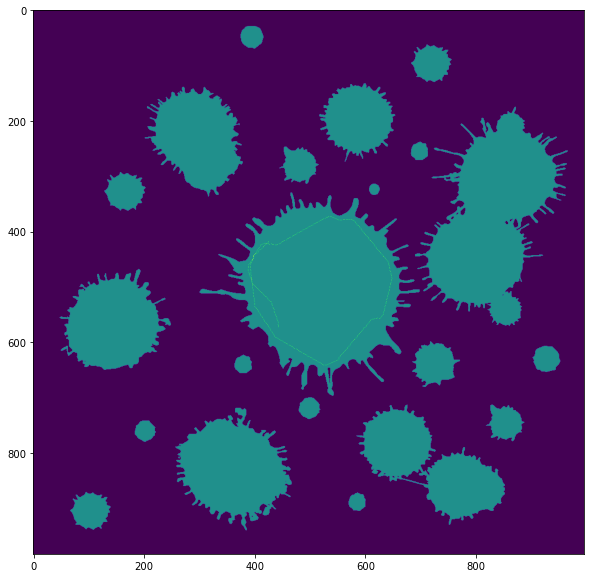

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.5128 - val_loss: 0.0880
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0664 - val_loss: 0.0874
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0609 - val_loss: 0.0498
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0582 - val_loss: 0.0263
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0554 - val_loss: 0.1111
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.1722 - val_loss: 0.0085
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0346 - val_loss: 0.0706
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0643 - val_loss: 0.0505
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.0577 - val_loss: 0.0499
E

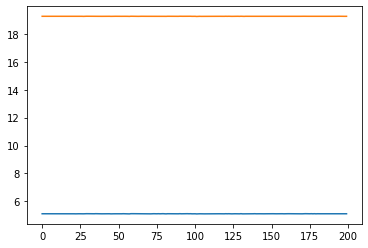

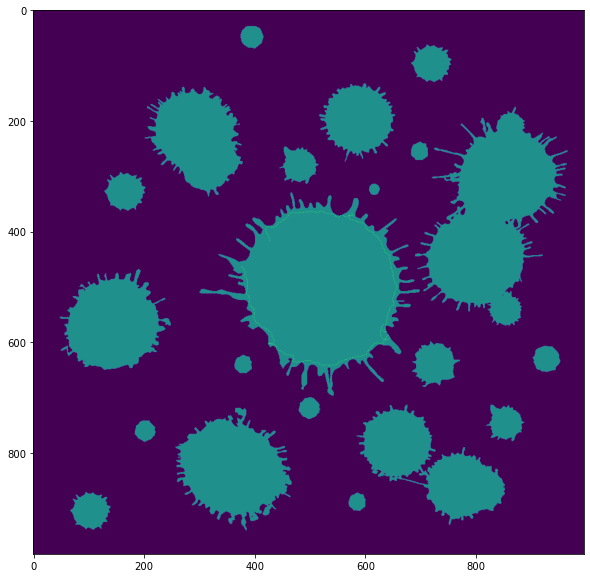

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.5536 - val_loss: 0.1586
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.0907 - val_loss: 0.1052
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.0435 - val_loss: 0.0099
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 9.9363 - val_loss: 0.1150
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 10.0301 - val_loss: 0.0848
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 12.2722 - val_loss: 0.1234
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 12.2279 - val_loss: 0.0459
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 12.1394 - val_loss: 0.1949
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 13.3535 - val_loss: 

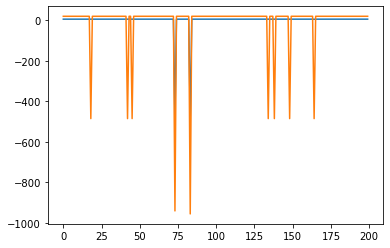

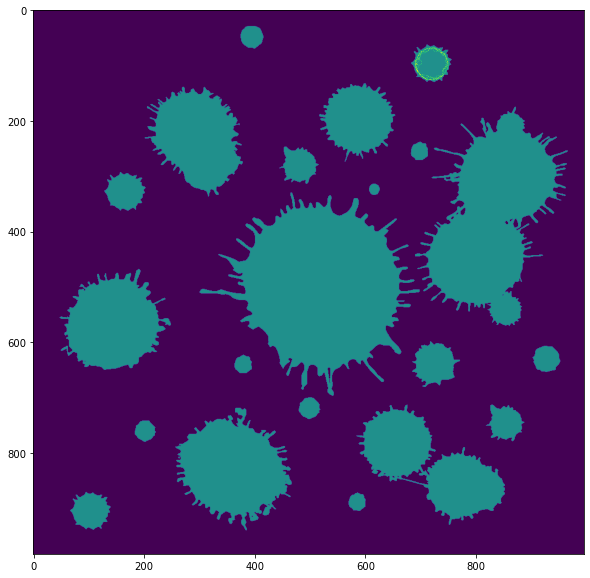

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.8553 - val_loss: 0.0197
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 3.8335 - val_loss: 0.0824
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.9121 - val_loss: 0.0086
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.9549 - val_loss: 0.0813
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 2.8987 - val_loss: 0.0725
Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.2475 - val_loss: 0.2233
Epoch 2/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.0345 - val_loss: 0.0227
Epoch 3/5
360/360 [==============================] - 1s 2ms/sample - loss: 3.9741 - val_loss: 0.1455
Epoch 4/5
360/360 [==============================] - 1s 2ms/sample - loss: 4.0370 - val_loss: 0.0280
E

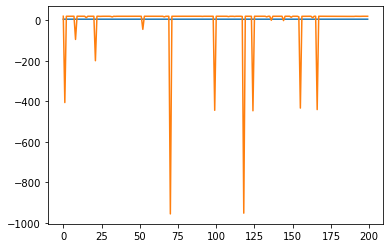

In [384]:

for train_step in range(99):
    if train_step%4==0:
        exploration=exploration*0
        populate_replay_memory(car, target_model, actions, replay_memory,
                               insert_index, replay_size, data_scaler, usescaler, train_step)
        np.random.shuffle(replay_memory)
        fig=plt.figure(figsize=(10, 10))
        plt.imshow(exploration+track1)
        plt.show()
        
    train_y=train_y*0
    train_y[:,0]=train_y[:,0]+replay_memory[:,23]
    train_y[:,1]=train_y[:,1]+replay_memory[:,24]
    train_x=replay_memory[:,inputcolumns]
    if usescaler:
        train_x=custom_scaler(train_x, data_scaler)
        
        
    make_consistent_net.fit(train_x, train_y, batch_size=1, epochs=5, verbose=1, shuffle=True,
                            validation_split=0.1, callbacks=[early_stop, history, learning_scheduler])
    
    
    val_loss_hist=val_loss_hist+history.history['val_loss']
    train_loss_hist=train_loss_hist+history.history['loss']
    
    
    if train_step%4==0:
        plt.plot(make_consistent_net.predict(train_x)[:200])
        plt.plot(0.96*target_model.predict(train_x)[:200].reshape((200, ))+replay_memory[:200, -2])
        
    target_model.set_weights(make_consistent_net.get_weights())
    update_replay_memory(target_model, actions, replay_memory,
                         data_scaler, usescaler)
    

    

In [319]:
print (train_step)

113


In [287]:
# 0.9*target_model.predict(train_x)[:1000].reshape((1000, ))+
a=make_consistent_net.predict(train_x)[:400].reshape((400, ))
b=replay_memory[:400, -2]
print(a.shape, b.shape)
sum(np.logical_and(a>-1, b<0))

(400,) (400,)


13

In [288]:
((make_consistent_net.predict(train_x))).max()

5.287975

In [401]:
make_consistent_net.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            multiple                  650       
_________________________________________________________________
layer_normalization_124 (Lay multiple                  100       
_________________________________________________________________
dense_201 (Dense)            multiple                  10200     
_________________________________________________________________
layer_normalization_125 (Lay multiple                  400       
_________________________________________________________________
dense_202 (Dense)            multiple                  4020      
_________________________________________________________________
layer_normalization_126 (Lay multiple                  40        
_________________________________________________________________
dense_203 (Dense)            multiple                